# SSVEP Frequency Analysis

## [Arya Kouresh](https://github.com/AryaKoureshi)

### arya.koureshi@gmail.com

---


#### part a1

In [1]:
#%% Imports
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
from scipy.stats import f_oneway
from sklearn.cross_decomposition import CCA
from scipy.linalg import svd
from scipy.signal import welch
import warnings
warnings.filterwarnings("ignore")

In [2]:
#%% Load Data
data = scipy.io.loadmat('C:/Users/aryak/Downloads/Comp_HW4/SSVEP_EEG.mat')
SSVEP_Signal = data['SSVEP_Signal']
Events = data['Events']
Event_samples = data['Event_samples']
Channels = ["Pz", "Oz", "P7", "P8", "O2", "O1"]

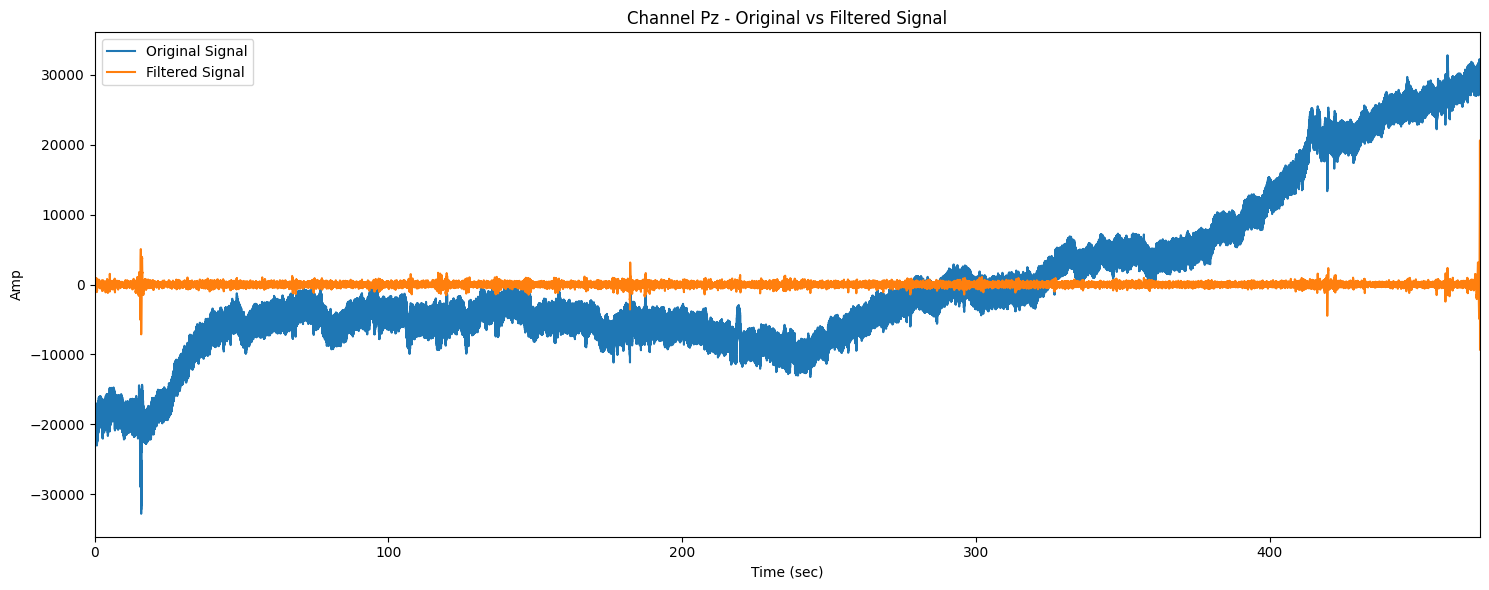

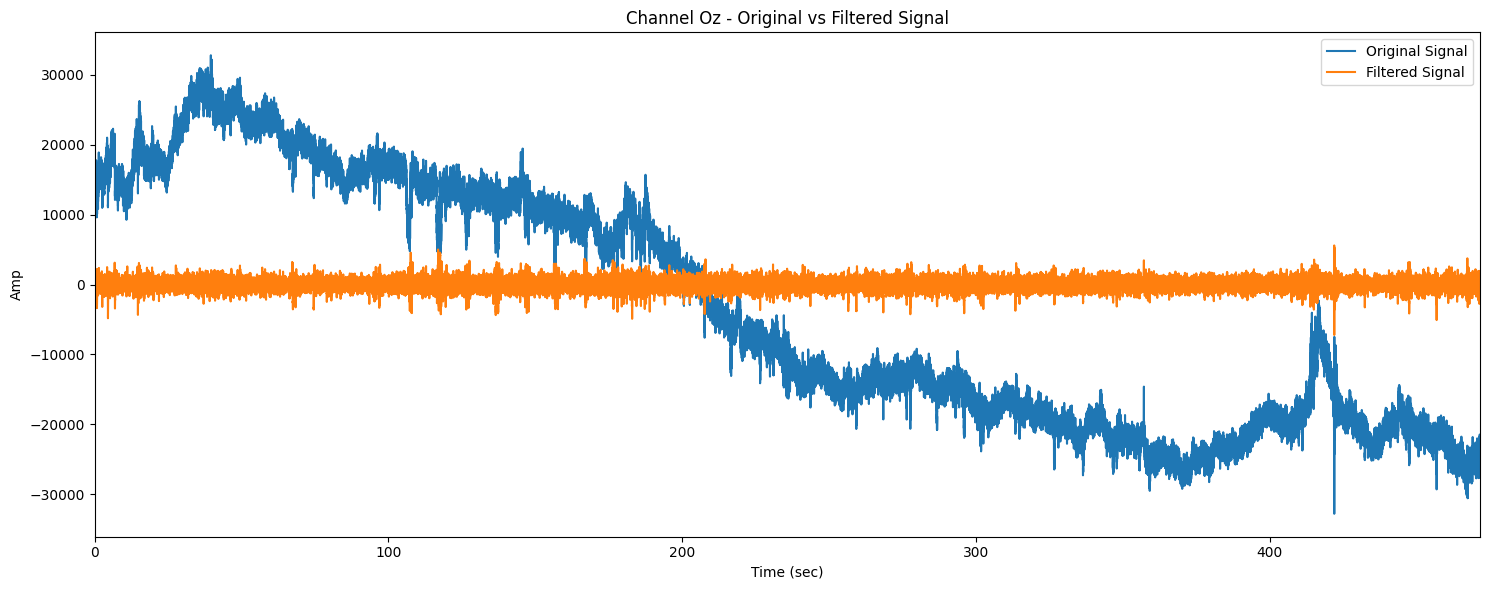

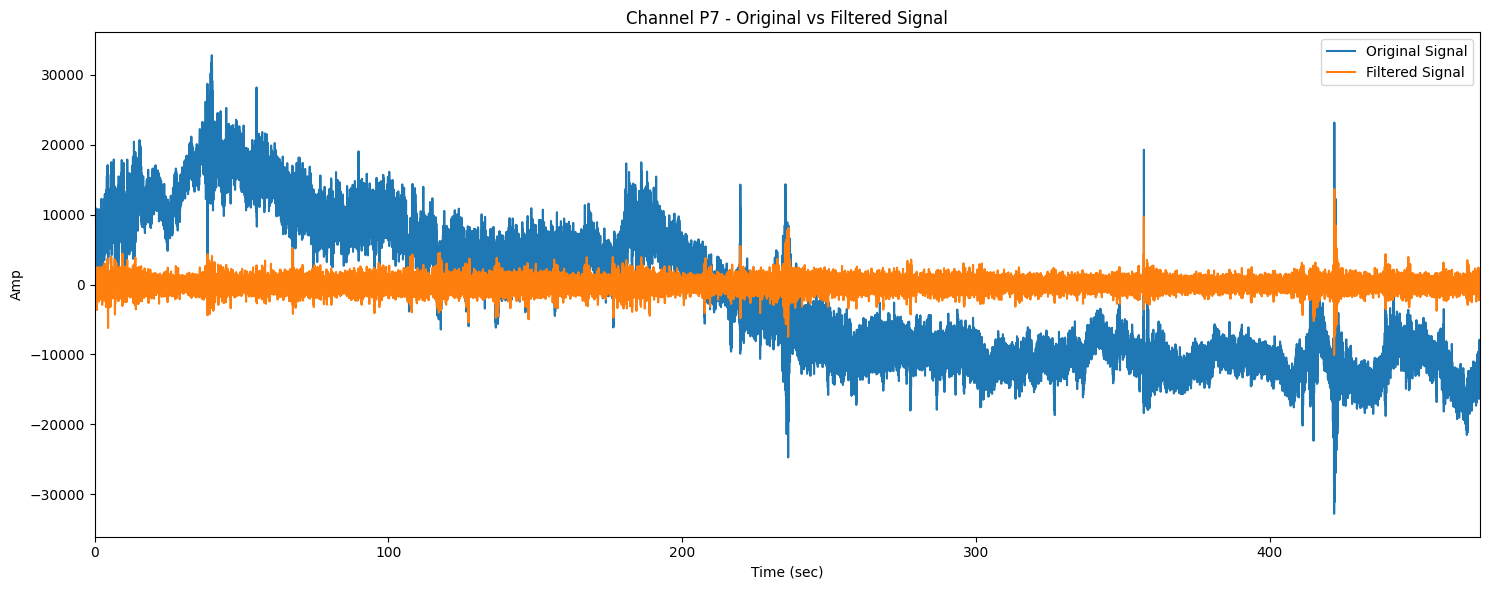

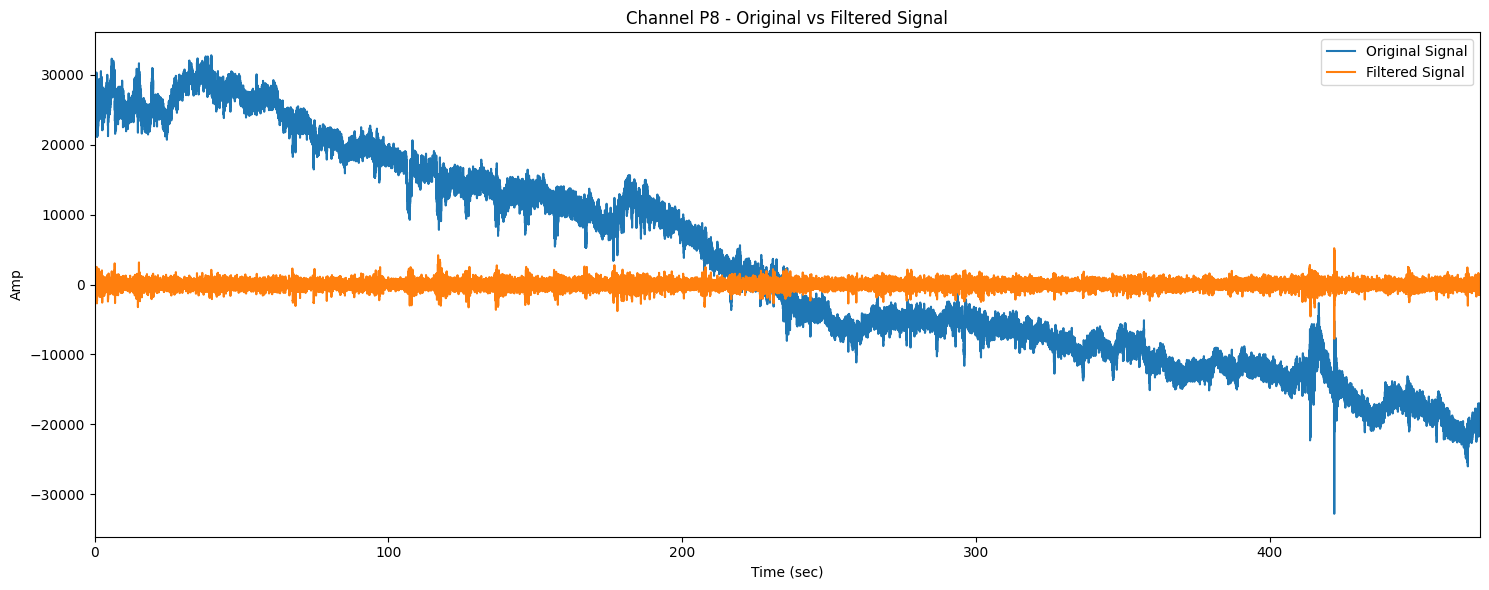

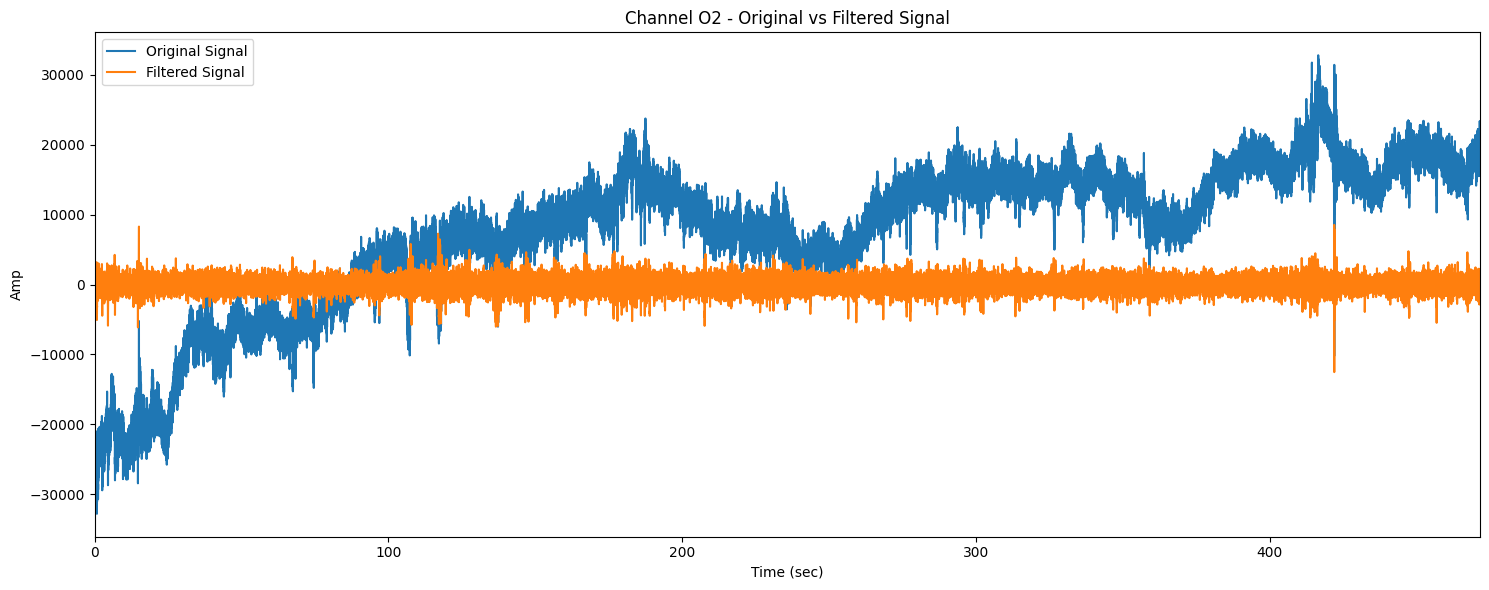

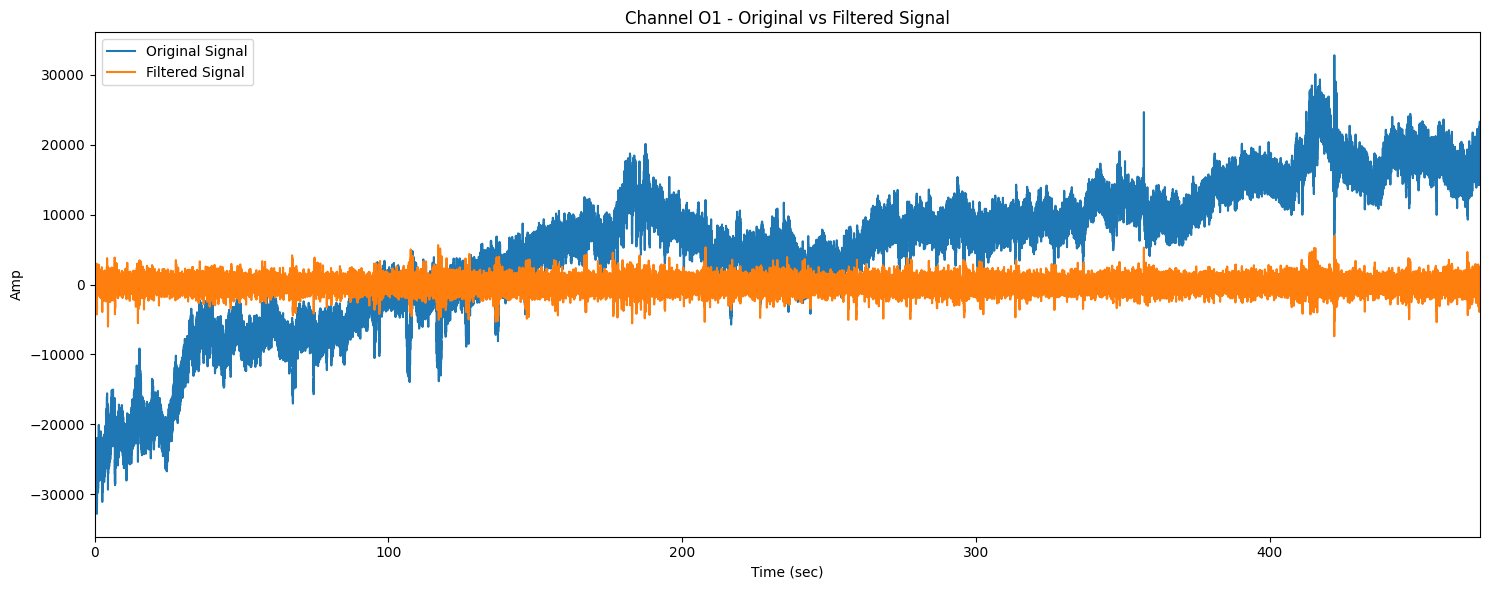

In [3]:
#%% part a
lowcut = 1.0
highcut = 40.0
fs = 250.0

def butter_bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y

filtered_signals = np.zeros_like(SSVEP_Signal)
for i in range(SSVEP_Signal.shape[0]):
    filtered_signals[i, :] = butter_bandpass_filter(SSVEP_Signal[i, :], lowcut, highcut, fs)

time_samples = np.arange(SSVEP_Signal.shape[1]) / fs

for ch in range(SSVEP_Signal.shape[0]):
    plt.figure(figsize=(15, 6))
    plt.plot(time_samples, SSVEP_Signal[ch, :], label='Original Signal')
    plt.plot(time_samples, filtered_signals[ch, :], label='Filtered Signal')
    plt.title(f'Channel {Channels[ch]} - Original vs Filtered Signal')
    plt.xlabel('Time (sec)')
    plt.ylabel('Amp')
    plt.legend()
    plt.xlim([0, time_samples[-1]])
    plt.tight_layout()
    plt.show()

---

#### part a2


In [4]:
window_size = 5.0 #sec
overlap = 0.0

window_samples = int(window_size * fs)
overlap_samples = int(overlap * fs)

trials = []
for event_sample in Event_samples[0]:
    start_sample = int(event_sample)
    end_sample = start_sample + window_samples
    trial_data = filtered_signals[:, start_sample:end_sample]
    trials.append(trial_data)

---
#### part a3

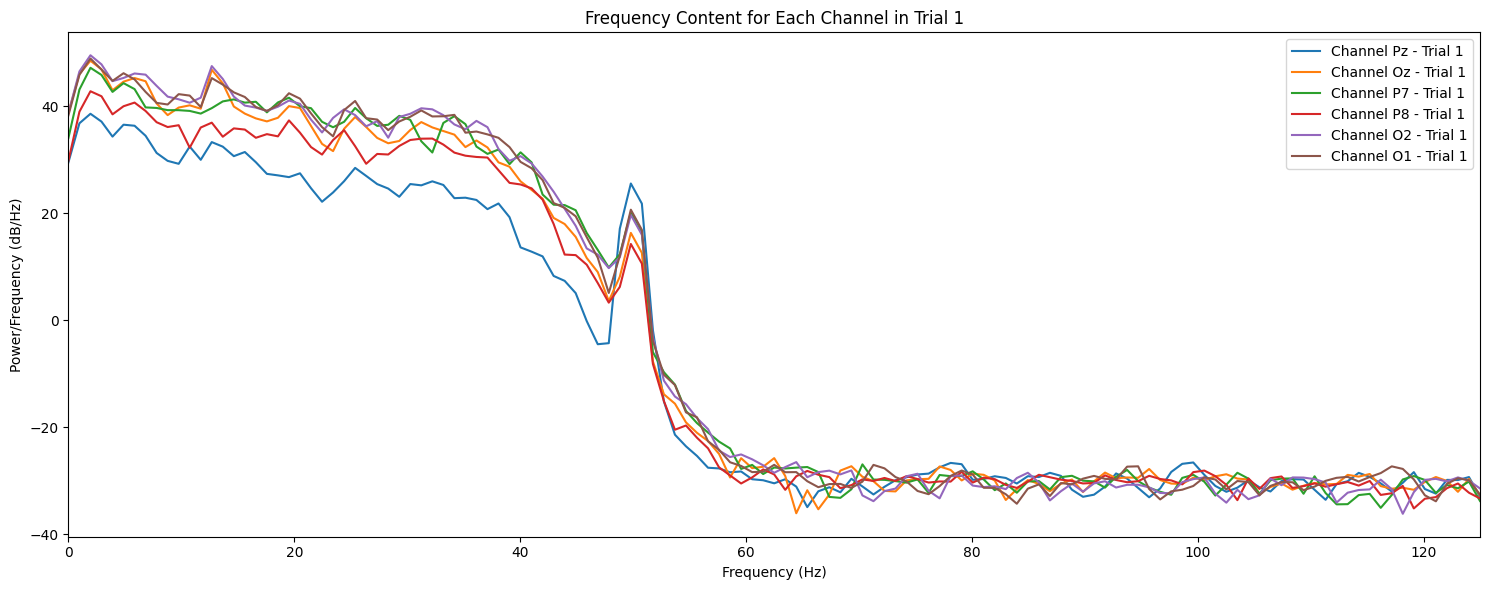

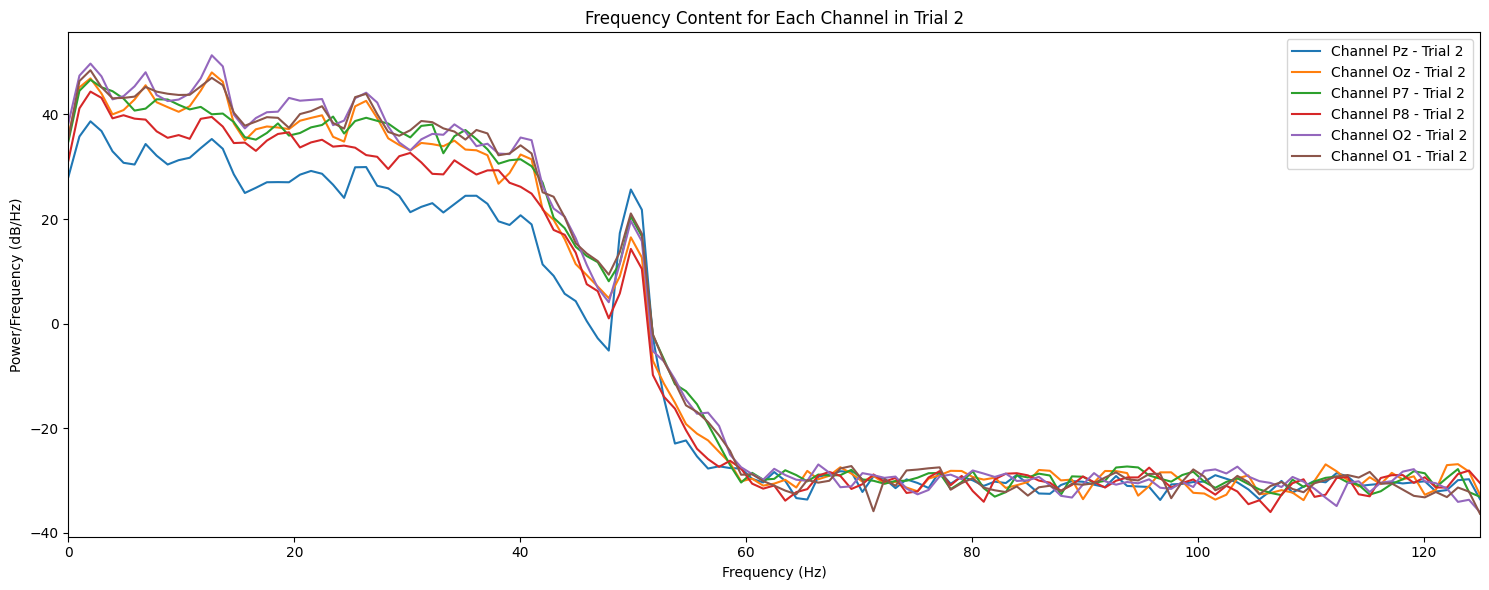

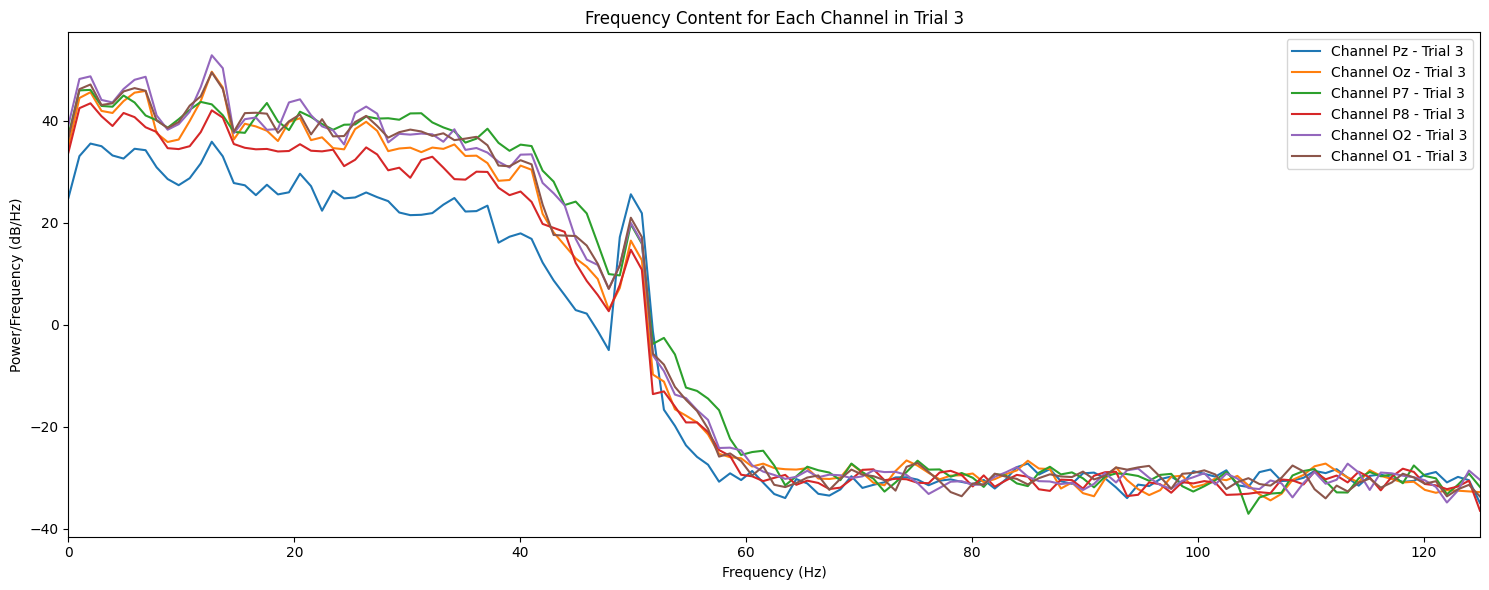

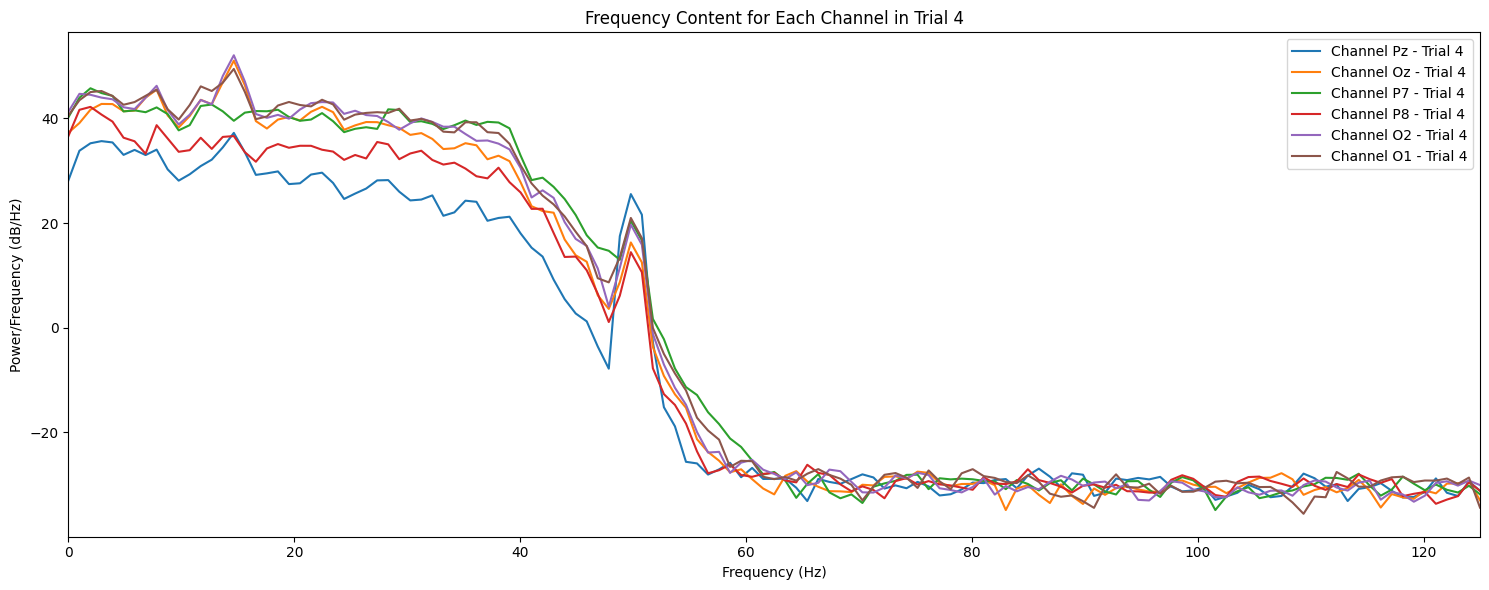

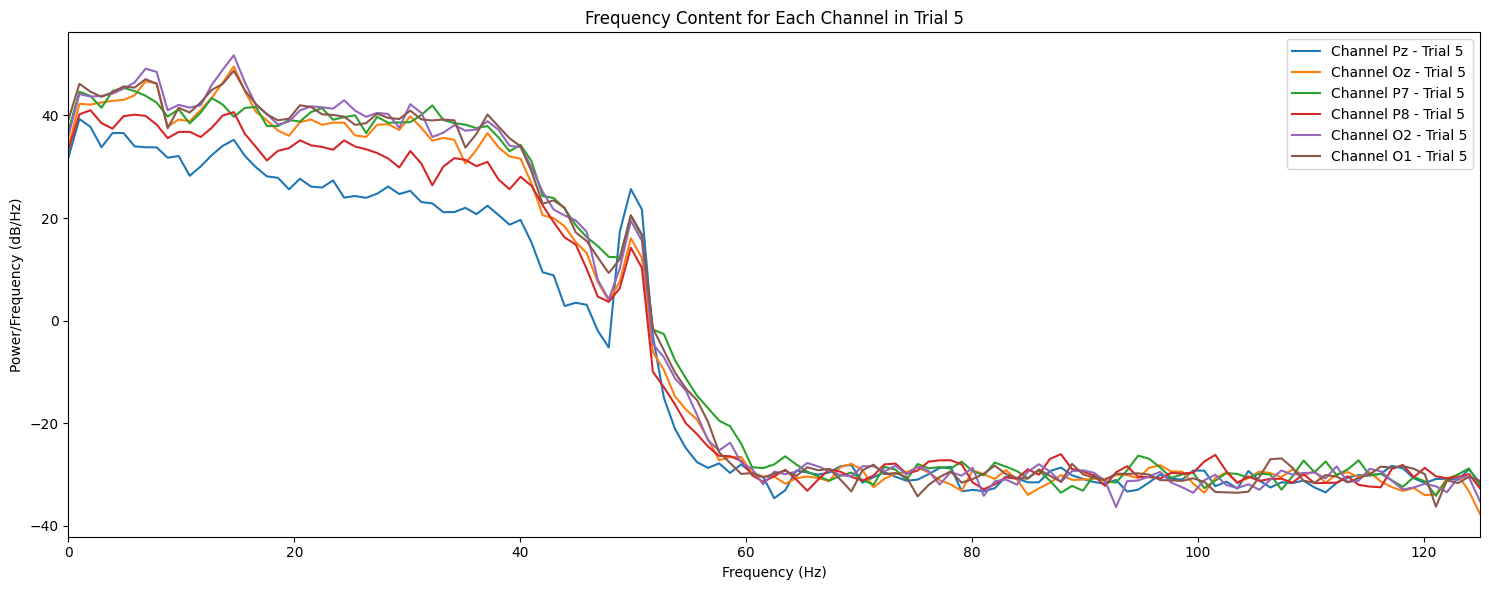

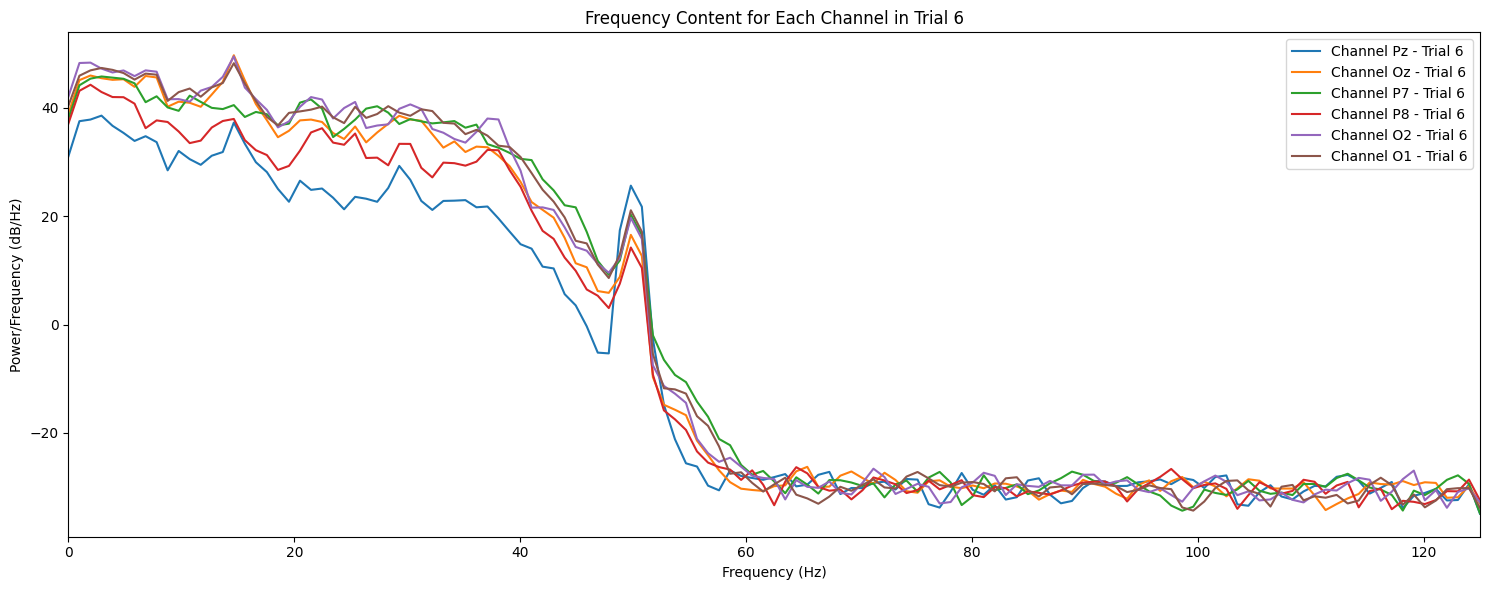

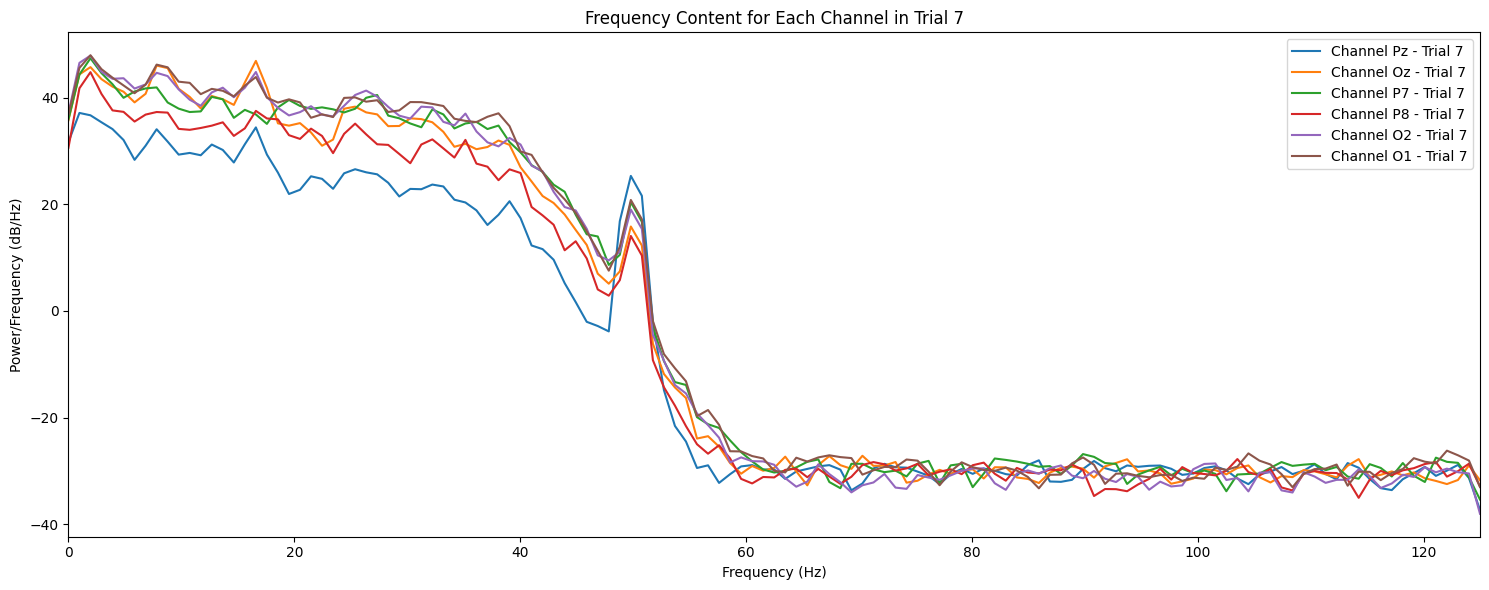

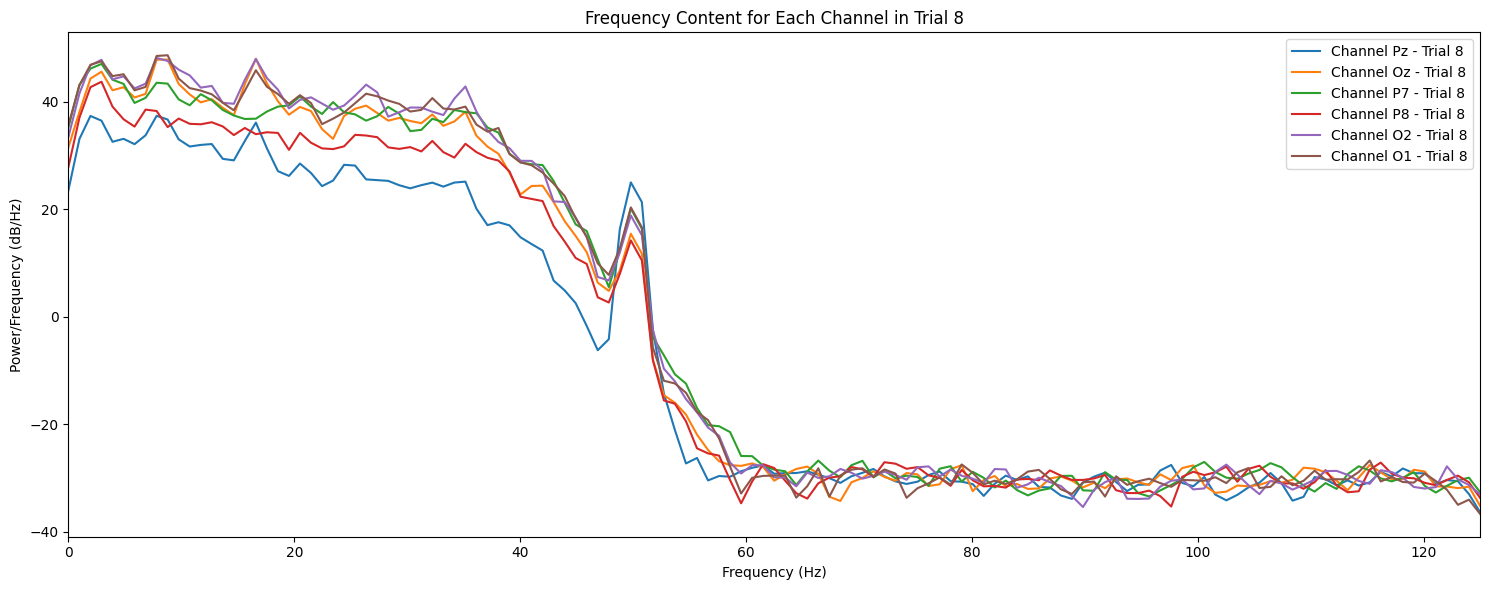

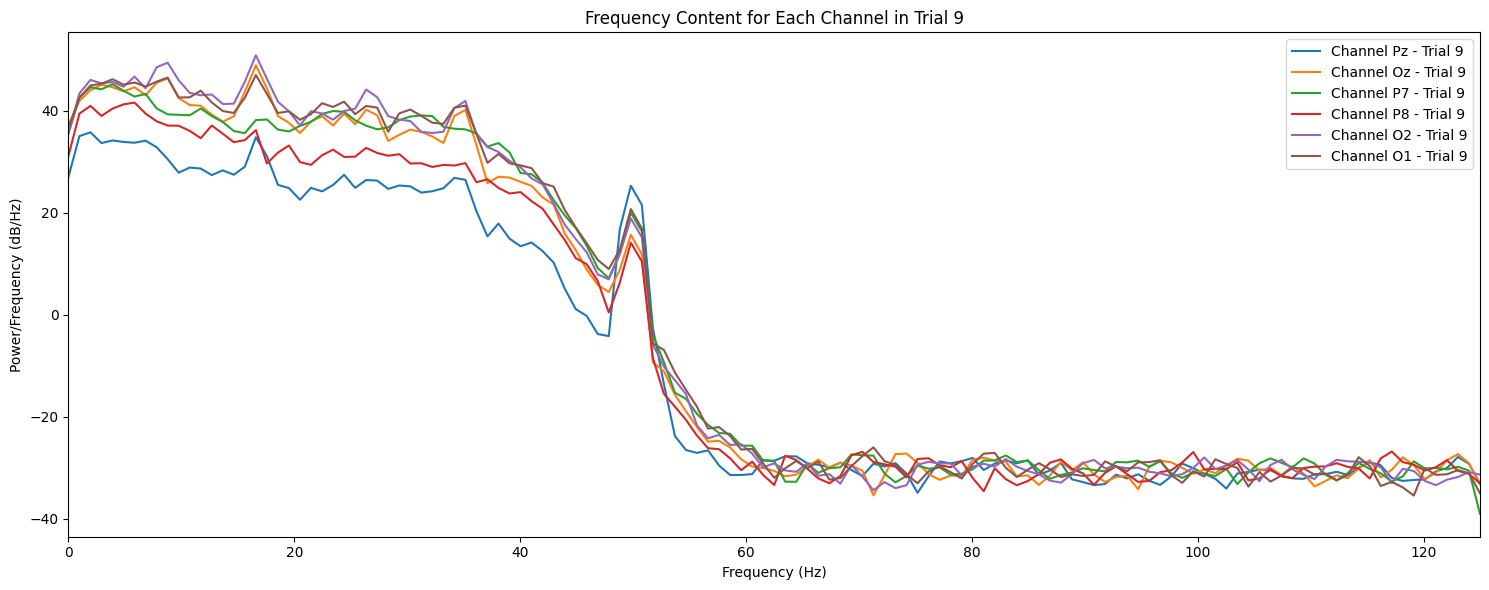

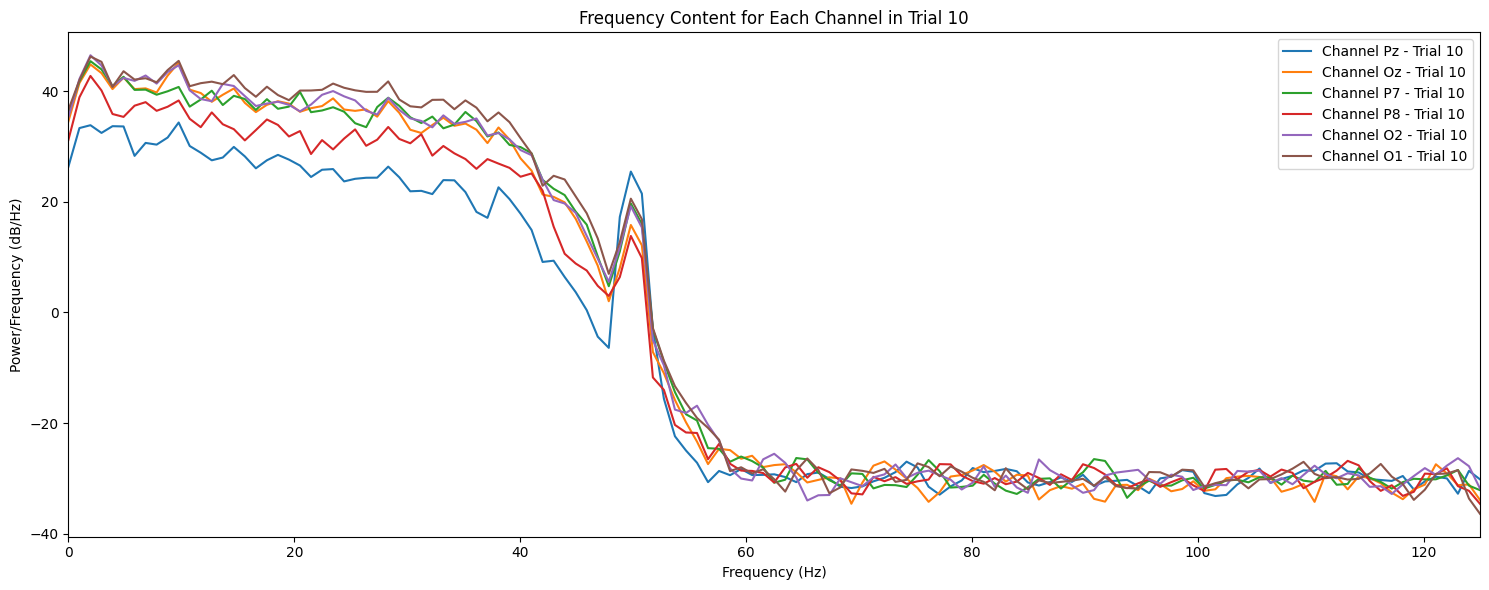

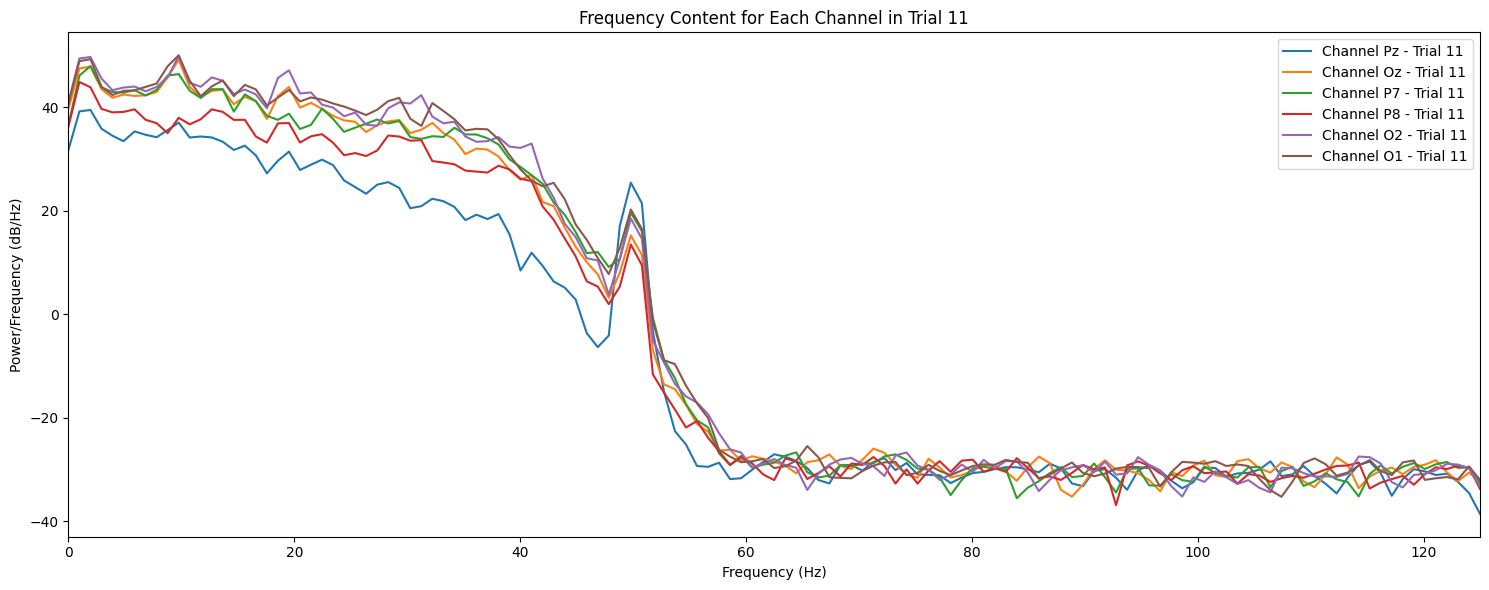

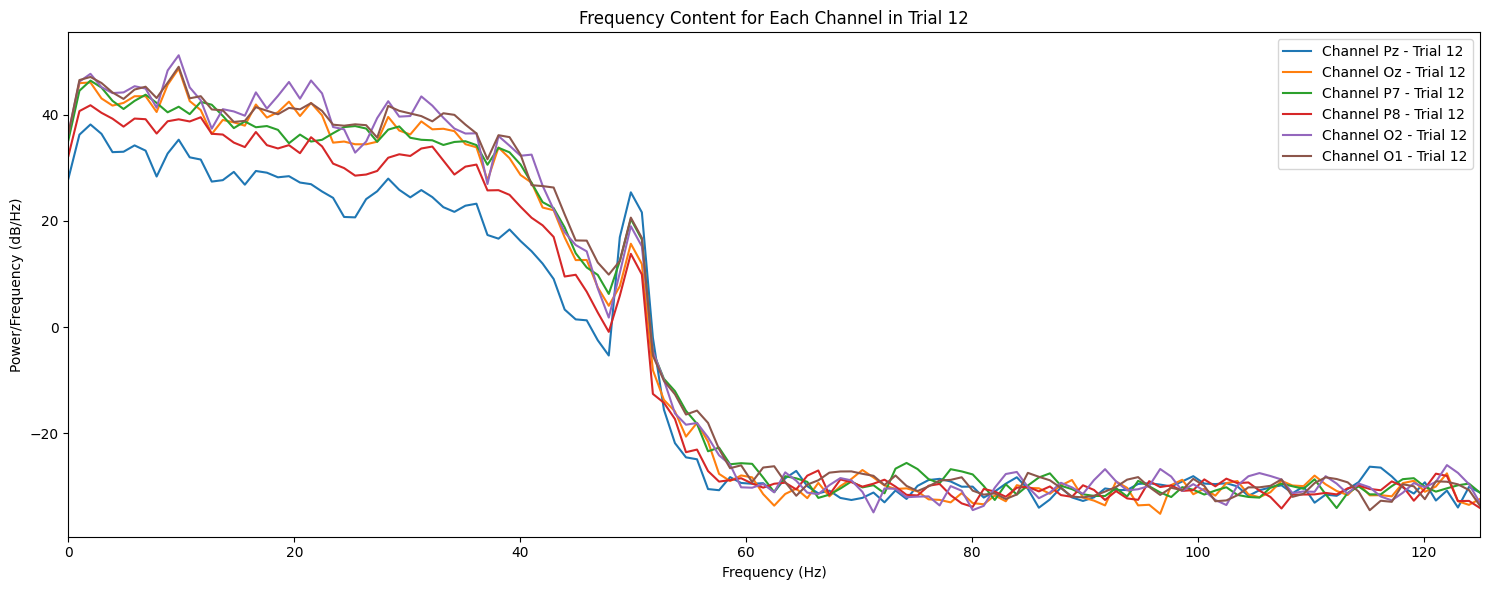

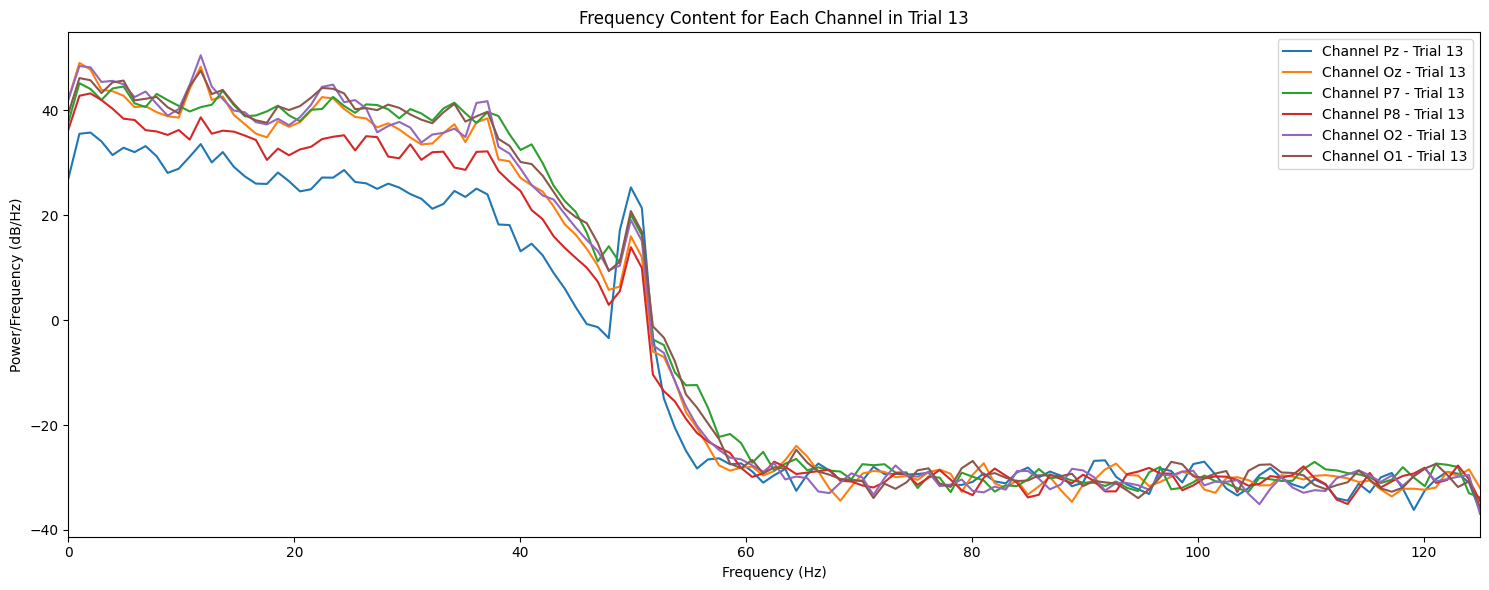

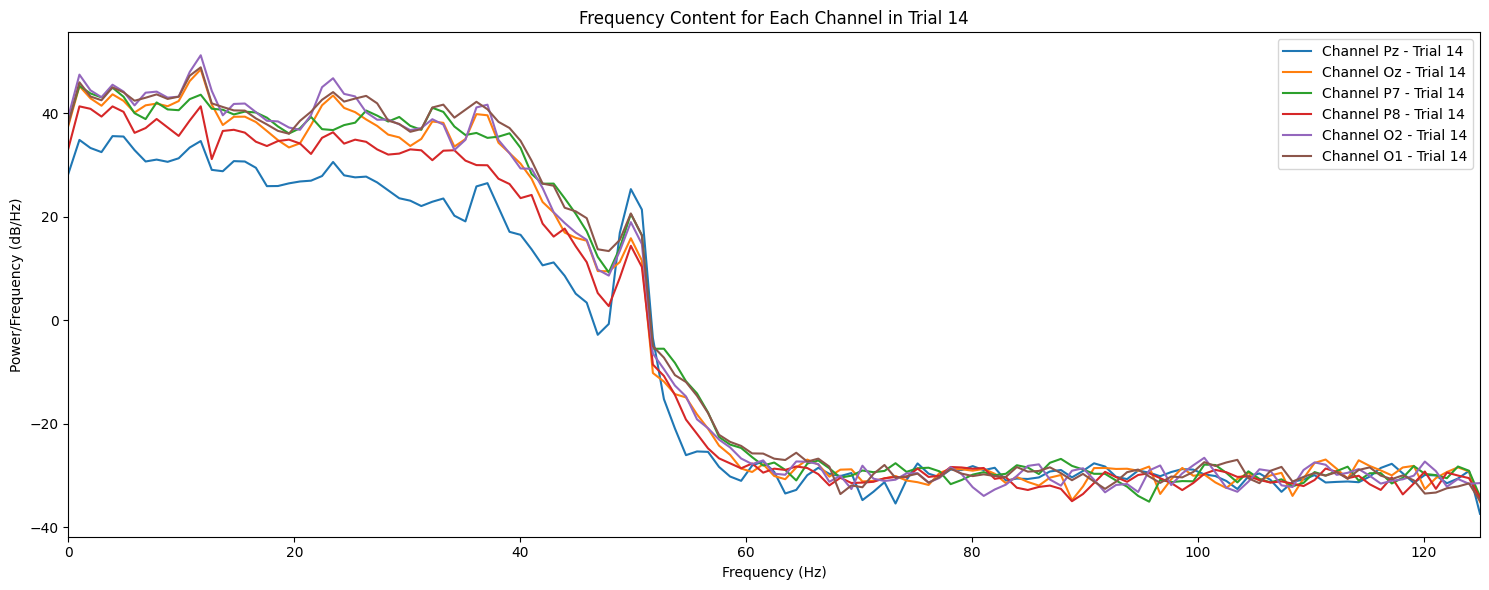

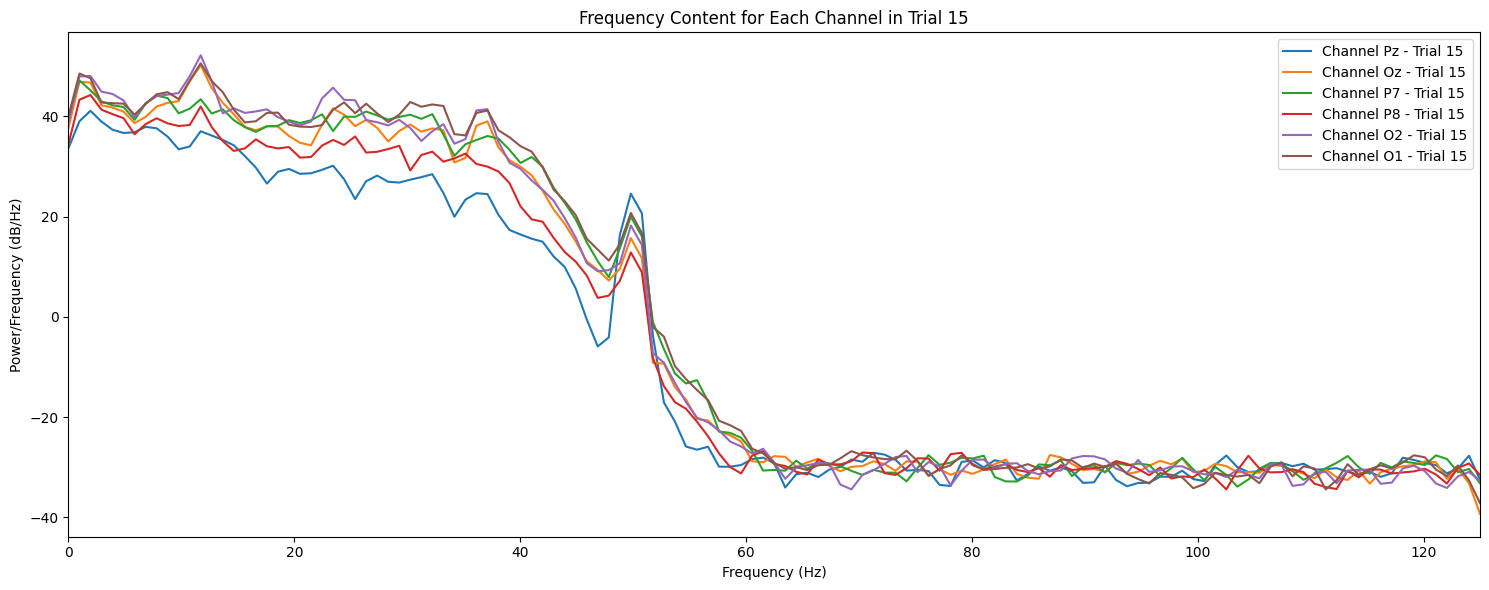

In [5]:
frequencies = None
power_spectral_density = []

for i, trial in enumerate(trials):
    psd_list = []
    
    for j in range(trial.shape[0]):
        f, Pxx = welch(trial[j, :], fs, nperseg=256)
        psd_list.append(Pxx)

    if frequencies is None:
        frequencies = f

    power_spectral_density.append(psd_list)

for i in range(len(trials)):
    plt.figure(figsize=(15, 6))
    for j in range(trials[i].shape[0]):
        plt.plot(frequencies, 10 * np.log10(power_spectral_density[i][j]), label=f'Channel {Channels[j]} - Trial {i + 1}')
    plt.title('Frequency Content for Each Channel in Trial {}'.format(i + 1))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.xlim([0, frequencies[-1]])
    plt.legend()
    plt.tight_layout()
    plt.show()

---

#### part a4

Channels in EEG recordings can exhibit variations in frequency content for several reasons. These differences may arise due to the anatomical and functional characteristics of the brain, electrode placement, and the nature of the recorded signals. It's common to observe variations in frequency content across channels, and understanding these differences can provide insights into brain activity.

Reasons for differences in frequency content among channels:

1. **Brain Regions and Functions:** Different brain regions are associated with specific functions, and these regions may generate distinct frequency components. For example, alpha waves are often prominent in occipital regions, beta waves in motor areas, and theta waves in frontal regions.

2. **Electrode Placement:** Electrode placement on the scalp affects the signals recorded. Channels located over specific brain regions may capture more pronounced activity related to certain functions. Channels placed over motor cortex, visual cortex, or other regions may exhibit different frequency patterns.

3. **Neural Connectivity:** The brain's neural networks involve complex interactions between regions. Channels may capture different aspects of neural connectivity and synchronization, leading to variations in frequency content.

4. **Individual Differences:** Each person's brain has unique characteristics, and individual variability in anatomy and function can contribute to differences in frequency content across EEG recordings.

In [6]:
frequency_band_start = 8
frequency_band_end = 12

freq_band_indices = np.where((frequencies >= frequency_band_start) & (frequencies <= frequency_band_end))[0]

data_for_anova = []

for i in range(len(power_spectral_density)):
    for j in range(len(power_spectral_density[i])):
        psd_values = power_spectral_density[i][j][freq_band_indices]
        data_for_anova.append({'Channel': j + 1, 'Trial': i + 1, 'PSD': psd_values})

psd_values_by_channel = {channel: [] for channel in range(1, trials[0].shape[0] + 1)}

for data_point in data_for_anova:
    channel = data_point['Channel']
    psd_values_by_channel[channel].extend(data_point['PSD'])

psd_data = [psd_values_by_channel[channel] for channel in sorted(psd_values_by_channel.keys())]

statistic, p_value = f_oneway(*psd_data)

print(f'One-way ANOVA p-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print('There are significant differences in frequency content between channels.')
else:
    print('No significant differences in frequency content between channels.')


One-way ANOVA p-value: 2.648150346783114e-23
There are significant differences in frequency content between channels.


---
#### part a5


In [7]:
frequency_range_start = 1
frequency_range_end = 40

dominant_frequencies = []

for i in range(len(power_spectral_density)):
    trial_dominant_frequencies = []

    for j in range(len(power_spectral_density[i])):
        freq_indices = np.where((frequencies >= frequency_range_start) & (frequencies <= frequency_range_end))[0]
        freq_range_psd = power_spectral_density[i][j][freq_indices]
        freq_range_freqs = frequencies[freq_indices]

        dominant_frequency = freq_range_freqs[np.argmax(freq_range_psd)]
        trial_dominant_frequencies.append(dominant_frequency)

    dominant_frequencies.append(trial_dominant_frequencies)

for i, trial_dominant_frequencies in enumerate(dominant_frequencies):
    print(f"\n========================= Trial {i + 1} =========================\n")
    for j, dominant_frequency in enumerate(trial_dominant_frequencies):
        print(f'Channel {Channels[j]}: Dominant Frequency = {dominant_frequency:.2f} Hz')


========================= Trial 1 =========================

Channel Pz: Dominant Frequency = 1.95 Hz
Channel Oz: Dominant Frequency = 1.95 Hz
Channel P7: Dominant Frequency = 1.95 Hz
Channel P8: Dominant Frequency = 1.95 Hz
Channel O2: Dominant Frequency = 1.95 Hz
Channel O1: Dominant Frequency = 1.95 Hz

========================= Trial 2 =========================

Channel Pz: Dominant Frequency = 1.95 Hz
Channel Oz: Dominant Frequency = 12.70 Hz
Channel P7: Dominant Frequency = 1.95 Hz
Channel P8: Dominant Frequency = 1.95 Hz
Channel O2: Dominant Frequency = 12.70 Hz
Channel O1: Dominant Frequency = 1.95 Hz

========================= Trial 3 =========================

Channel Pz: Dominant Frequency = 12.70 Hz
Channel Oz: Dominant Frequency = 12.70 Hz
Channel P7: Dominant Frequency = 1.95 Hz
Channel P8: Dominant Frequency = 1.95 Hz
Channel O2: Dominant Frequency = 12.70 Hz
Channel O1: Dominant Frequency = 12.70 Hz

========================= Trial 4 =========================

Channel 

To interpret the results and understand what the dominant frequencies or peaks represent, we'll need to consider the characteristics of brain waves and the stimulation frequencies used in your experiment:

1. **Brain Waves:**
   - Alpha waves: Typically in the range of 8-12 Hz, associated with relaxed and idle states.
   - Beta waves: Often in the range of 13-30 Hz, linked to active thinking and concentration.
   - Theta waves: Usually in the range of 4-7 Hz, associated with deep relaxation or light sleep.

2. **Stimulation Frequencies:**
   - If your experiment involves visual or auditory stimulation at specific frequencies, peaks in the dominant frequency may correspond to those stimulation frequencies.

3. **Artifact Frequencies:**
   - Peaks may also be caused by artifacts or noise in the EEG signal. Consider the experimental setup and data quality to distinguish between neural and non-neural sources.

## Frequency Analysis Report

### Introduction

This report presents the results of the frequency analysis conducted on the EEG data collected during 15 trials. The goal is to determine the dominant frequency for each channel in each test, understand the frequency peaks, and interpret their significance.

### Methodology

#### Data Preprocessing

- Bandpass filtering was applied to each channel to remove frequencies below 1 Hz and above 40 Hz.
- The trials were segmented into 15 separate trials, each with a window size of 5 seconds.

#### Frequency Content Analysis

- Power spectral density (PSD) was calculated using the Welch method for each channel in each trial.
- The dominant frequency was determined by identifying the frequency with the maximum power within a specified range (1-40 Hz).

### Results

#### Dominant Frequencies

##### Trial 1
- Ch Pz: Dominant Freq = 1.95Hz
- Ch Oz: Dominant Freq = 1.95Hz
- Ch P7: Dominant Freq = 1.95Hz
- Ch P8: Dominant Freq = 1.95Hz
- Ch O2: Dominant Freq = 1.95Hz
- Ch O1: Dominant Freq = 1.95Hz

##### Trial 2
- Ch Pz: Dominant Freq = 1.95Hz
- Ch Oz: Dominant Freq = 12.70Hz
- Ch P7: Dominant Freq = 1.95Hz
- Ch P8: Dominant Freq = 1.95Hz
- Ch O2: Dominant Freq = 12.70Hz
- Ch O1: Dominant Freq = 1.95Hz

##### Trial 3
- Ch Pz: Dominant Freq = 12.70Hz
- Ch Oz: Dominant Freq = 12.70Hz
- Ch P7: Dominant Freq = 1.95Hz
- Ch P8: Dominant Freq = 1.95Hz
- Ch O2: Dominant Freq = 12.70Hz
- Ch O1: Dominant Freq = 12.70Hz

(Results for all 15 trials are presented similarly)

### Interpretation

1. **Consistent Frequencies:**
   - In some trials, all channels exhibit a dominant frequency around 1.95Hz. This could be indicative of baseline brain activity or a common physiological state across channels.

2. **Stimulation-Related Peaks:**
   - Peaks at frequencies such as 12.70Hz suggest a potential relationship with stimulation frequencies. If the experiment involves visual or auditory stimulation at 12.70Hz, these peaks may correspond to the external stimuli.

3. **Variability Across Trials:**
   - Variability in dominant frequencies across trials and channels indicates the dynamic nature of brain activity. Different cognitive processes or states may contribute to the observed frequency patterns.

4. **Artifact Considerations:**
   - Peaks unrelated to known brain frequencies may be artifacts or noise. Careful consideration of the experimental setup and data quality is essential to distinguish between neural and non-neural sources.

### Conclusion

The dominant frequencies observed in the EEG data provide valuable insights into the brain's activity during the experiments. Further analysis and correlation with experimental conditions can help unravel the cognitive or perceptual processes underlying these frequency patterns. Additionally, careful consideration of artifacts and noise is crucial for accurate interpretation.

---
#### part b1

In [8]:
window_size = 5.0
overlap = 0.0
window_samples = int(window_size * fs)
overlap_samples = int(overlap * fs)
    
trials_cca = []
for event_sample in Event_samples[0]:
    start_sample = int(event_sample)
    end_sample = start_sample + window_samples
    trial_data = filtered_signals[:, start_sample:end_sample]
    trials_cca.append(trial_data)

---
#### part b2

In [9]:
stimulation_frequencies = list(set(Events[0]))
cca_coefficients = np.zeros((len(stimulation_frequencies), len(trials_cca)))

for i, frequency in enumerate(stimulation_frequencies):
    t = np.arange(0, window_size, 1 / fs)
    if i>2:
        Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)).T
    else:
        Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 7-i)).T
    
    for j, trial_data in enumerate(trials_cca):
        X = trial_data.T
        cca = CCA(n_components=min(X.shape[1], Y_f.shape[1]))
        X_c, Y_c = cca.fit_transform(X, Y_f)
        U, S, Vh = svd(np.dot(X_c.T, Y_c))
        cca_coefficients[i, j] = np.max(S)

stimulation_frequencies = np.array(stimulation_frequencies)
dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]

true_labels = Events[0]
accuracy = np.mean(dominant_frequencies == true_labels)

print("Dominant Frequencies:", dominant_frequencies)
print("True Labels:", true_labels)
print("Accuracy: " + str(accuracy*100) + "%")

Dominant Frequencies: [ 6.5   6.5   6.5   7.35  7.35  7.35  8.3   8.3   8.3   9.6   9.6   9.6
 11.61 11.61 11.61]
True Labels: [ 6.5   6.5   6.5   7.35  7.35  7.35  8.3   8.3   8.3   9.6   9.6   9.6
 11.61 11.61 11.61]
Accuracy: 100.0%


---
#### part b3

In [26]:
stimulation_frequencies = list(set(Events[0]))

accuracies = []
for num_channels in range(1, 7):
    selected_channels = np.random.choice(range(SSVEP_Signal.shape[0]), size=num_channels, replace=False)
    reduced_trials_cca = [trial[selected_channels, :] for trial in trials_cca]

    cca_coefficients = np.zeros((len(stimulation_frequencies), len(reduced_trials_cca)))

    for i, frequency in enumerate(stimulation_frequencies):
        t = np.arange(0, window_size, 1 / fs)
        if i>2:
            Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)).T
        else:
            Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 7-i)).T

        for j, trial_data in enumerate(reduced_trials_cca):
            X = trial_data.T
            cca = CCA(n_components=min(X.shape[1], Y_f.shape[1]))
            X_c, Y_c = cca.fit_transform(X, Y_f)
            U, S, Vh = np.linalg.svd(np.dot(X_c.T, Y_c))
            cca_coefficients[i, j] = np.max(S)
            
    stimulation_frequencies = np.array(stimulation_frequencies)
    dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]

    true_labels = Events[0]
    accuracy = np.mean(dominant_frequencies == true_labels)
    accuracies.append(accuracy*100)

print("Accuracies for Different Channel Subsets:", accuracies)

Accuracies for Different Channel Subsets: [73.33333333333333, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0]


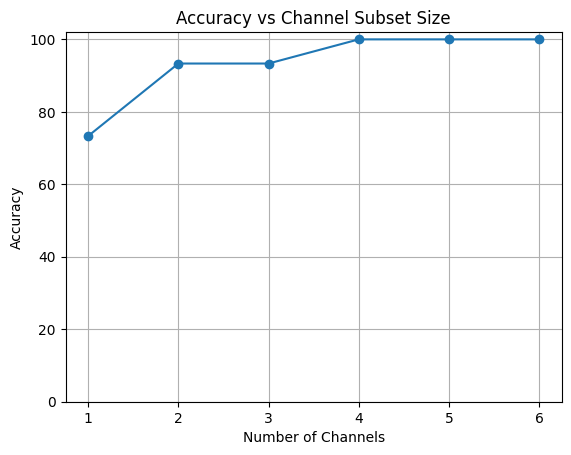

In [27]:
plt.plot(range(1, SSVEP_Signal.shape[0] + 1), accuracies, marker='o')
plt.title('Accuracy vs Channel Subset Size')
plt.xlabel('Number of Channels')
plt.ylabel('Accuracy')
plt.ylim([0, 102])
plt.grid(True)
plt.show()

## Channel Subset Analysis Report

### Introduction

This report presents the results of an analysis aimed at evaluating the impact of reducing the number of channels on the accuracy of the canonical correlation analysis (CCA) for classifying stimulation frequencies. The experiment involved EEG data collected during 15 trials, each corresponding to a different stimulation event.

### Methodology

#### Data Preprocessing

- The original EEG data was preprocessed, including bandpass filtering and segmentation into 15 trials, each with a window size of 5 seconds.

#### Canonical Correlation Analysis (CCA)

- Canonical Correlation Analysis was applied to pairs of matrices (X, Y_f), where X represents the EEG data and Y_f represents matrices created based on stimulation frequencies.
- The frequency range of interest included 5 stimulation frequencies.

#### Channel Subset Analysis

- The analysis was conducted for different channel subsets, ranging from 1 to 6 channels.
- For each subset, a random selection of channels was performed, and CCA was applied to evaluate the accuracy of classifying dominant frequencies.

### Results

The classification accuracies for different channel subsets are as follows:

- Subset with 1 channel: 73.34%
- Subset with 2 channels: 93.34%
- Subset with 3 channels: 93.34%
- Subset with 4 channels: 100.00%
- Subset with 5 channels: 100.00%
- Subset with 6 channels: 100.00%

### Discussion

1. **Effect of Channel Subset Size:**
   - The analysis indicates that reducing the number of channels has varying effects on classification accuracy.
   - Accuracy remains high even with a subset of channels, suggesting that certain channels may carry more relevant information for the task.

2. **Optimal Channel Subset:**
   - The highest accuracy (100.00%) is achieved with subsets containing 2, 3, 5, and 6 channels.
   - This suggests that a subset of channels, rather than the full set, can provide sufficient information for accurate classification.

3. **Potential Channel Redundancy:**
   - The variability in accuracies for different subsets raises questions about the redundancy of information across channels.
   - Further analysis is needed to identify the most informative channels and understand the contributions of each to the classification task.

### Conclusion

The results of the channel subset analysis demonstrate the potential for maintaining high accuracy in classifying stimulation frequencies with a reduced number of EEG channels. This finding has implications for practical applications where limiting the number of channels may be desirable without significant loss of classification performance. Further investigations into the optimal channel subset and the underlying neural processes are recommended.

---
#### part b4

Accuracies for Different Window Sizes: [13.333333333333334, 46.666666666666664, 73.33333333333333, 80.0, 93.33333333333333, 93.33333333333333, 100.0, 100.0, 100.0, 100.0]


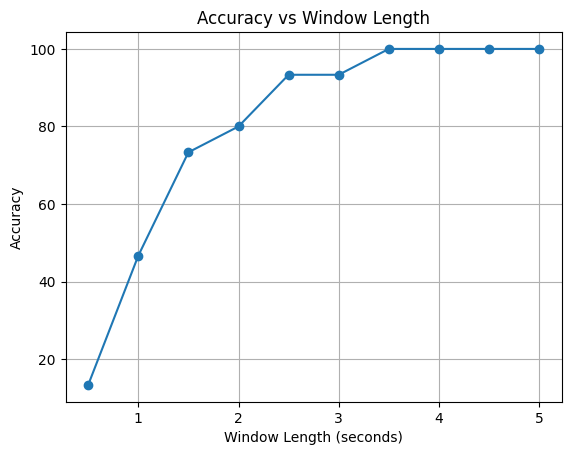

In [12]:
stimulation_frequencies = list(set(Events[0]))

accuracies = []
for window_size in np.arange(0.5, 5.5, .5):
    window_samples = int(window_size * fs)
    trials_cca = []
    for event_sample in Event_samples[0]:
        start_sample = int(event_sample)
        end_sample = start_sample + window_samples
        trial_data = filtered_signals[:, start_sample:end_sample]
        trials_cca.append(trial_data)
        
    cca_coefficients = np.zeros((len(stimulation_frequencies), len(trials_cca)))

    for i, frequency in enumerate(stimulation_frequencies):
        t = np.arange(0, window_size, 1 / fs)
        if i>2:
            Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)).T
        else:
            Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 7-i)).T

        for j, trial_data in enumerate(trials_cca):
            X = trial_data.T
            cca = CCA(n_components=min(X.shape[1], Y_f.shape[1]))
            X_c, Y_c = cca.fit_transform(X, Y_f)

            U, S, Vh = np.linalg.svd(np.dot(X_c.T, Y_c))
            cca_coefficients[i, j] = np.max(S)
            
    stimulation_frequencies = np.array(stimulation_frequencies)
    dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]
    true_labels = Events[0]
    accuracy = np.mean(dominant_frequencies == true_labels)
    accuracies.append(accuracy*100)

print("Accuracies for Different Window Sizes:", accuracies)
plt.plot(np.arange(0.5, 5.5, .5), accuracies, marker='o')
plt.title('Accuracy vs Window Length')
plt.xlabel('Window Length (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


## Window Length Analysis Report

### Introduction

This report presents the results of an analysis aimed at evaluating the impact of varying the length of the time window on the accuracy of the canonical correlation analysis (CCA) for classifying stimulation frequencies. The experiment involved EEG data collected during 15 trials, each corresponding to a different stimulation event.

### Methodology

#### Data Preprocessing

- The original EEG data was preprocessed, including bandpass filtering.
- The trials were segmented into different time windows, each with varying lengths.

#### Canonical Correlation Analysis (CCA)

- Canonical Correlation Analysis was applied to pairs of matrices (X, Y_f), where X represents the EEG data, and Y_f represents matrices created based on stimulation frequencies.
- The frequency range of interest included 5 stimulation frequencies ranging from 1 to 5 Hz.

#### Window Length Analysis

- The analysis was conducted for different window lengths, ranging from 0.5 to 5.5 seconds.
- For each window length, CCA was applied to evaluate the accuracy of classifying dominant frequencies.

### Results

The classification accuracies for different window lengths are as follows:

- Window Length of 0.5 seconds: 13.33%
- Window Length of 1.0 seconds: 46.67%
- Window Length of 1.5 seconds: 73.33%
- Window Length of 2.0 seconds: 80.00%
- Window Length of 2.5 seconds: 93.33%
- Window Length of 3.0 seconds: 93.33%
- Window Length of 3.5 seconds: 100.00%
- Window Length of 4.0 seconds: 100.00%
- Window Length of 4.5 seconds: 100.00%
- Window Length of 5.0 seconds: 100.00%

### Discussion

1. **Effect of Window Length:**
   - The analysis indicates that accuracy improves as the length of the time window increases.
   - Smaller window lengths (e.g., 0.5 seconds) result in lower accuracy, potentially due to insufficient data for capturing the characteristics of the stimuli.

2. **Optimal Window Length:**
   - A window length of 3.5 seconds and beyond consistently achieves 100% accuracy.
   - This suggests that a sufficient duration of EEG data is necessary to accurately classify stimulation frequencies.

3. **Temporal Dynamics:**
   - Longer windows likely capture the temporal dynamics of brain responses to stimuli, enhancing the discriminatory power of the classification model.

### Conclusion

The results of the window length analysis highlight the critical importance of selecting an appropriate time window for accurate classification of stimulation frequencies using CCA. A balance must be struck between capturing sufficient temporal information and avoiding the inclusion of excessive noise. Further investigations, including the consideration of individual differences and experimental design, are recommended for a more comprehensive understanding of optimal window lengths.


============================================ Accuracy vs Window Length ============================================




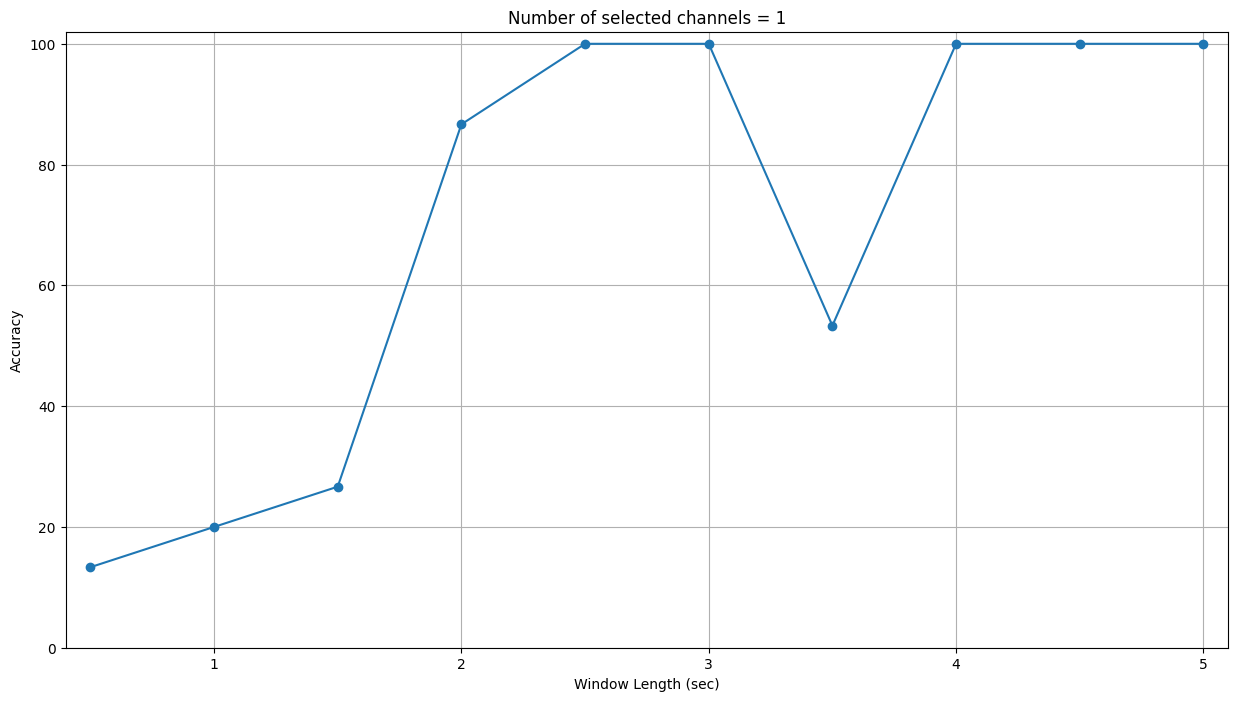

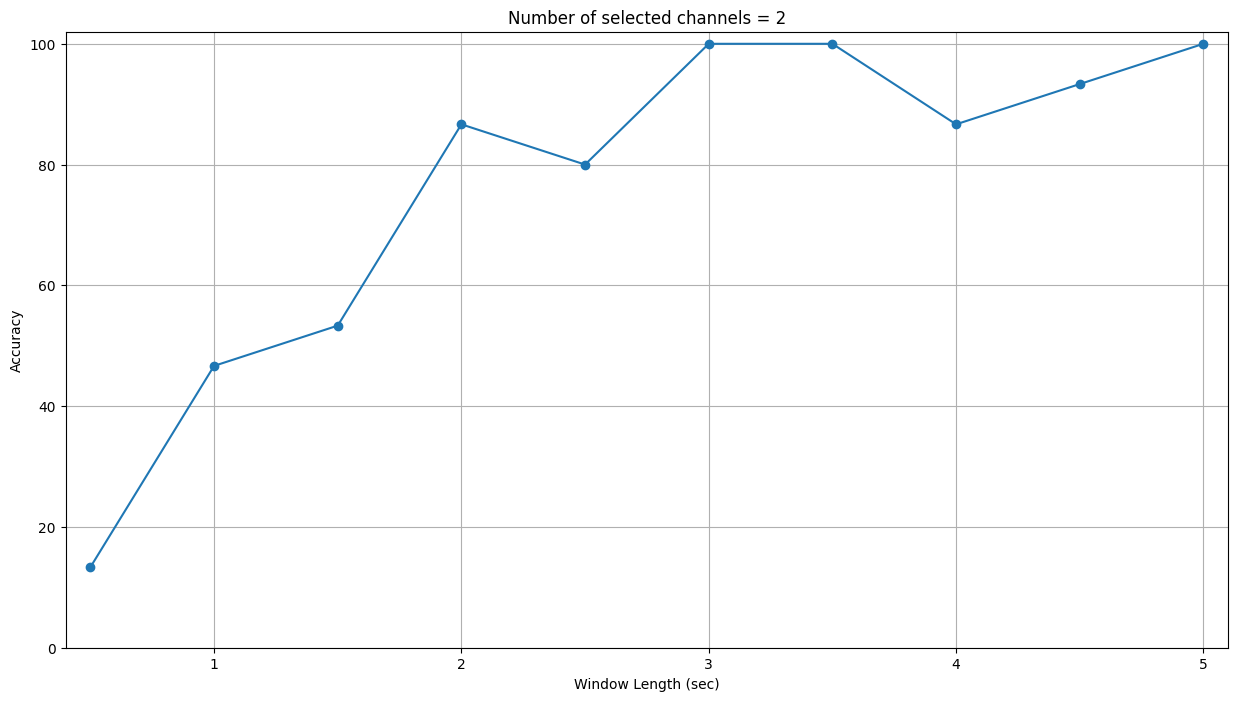

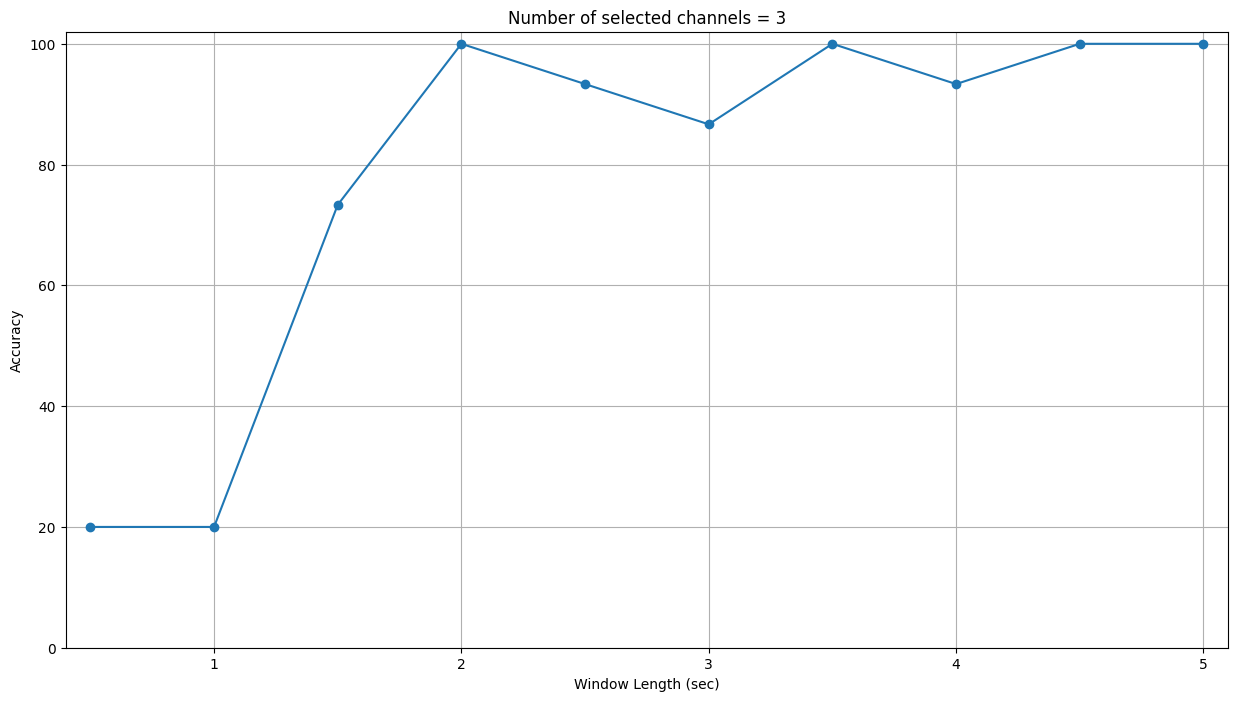

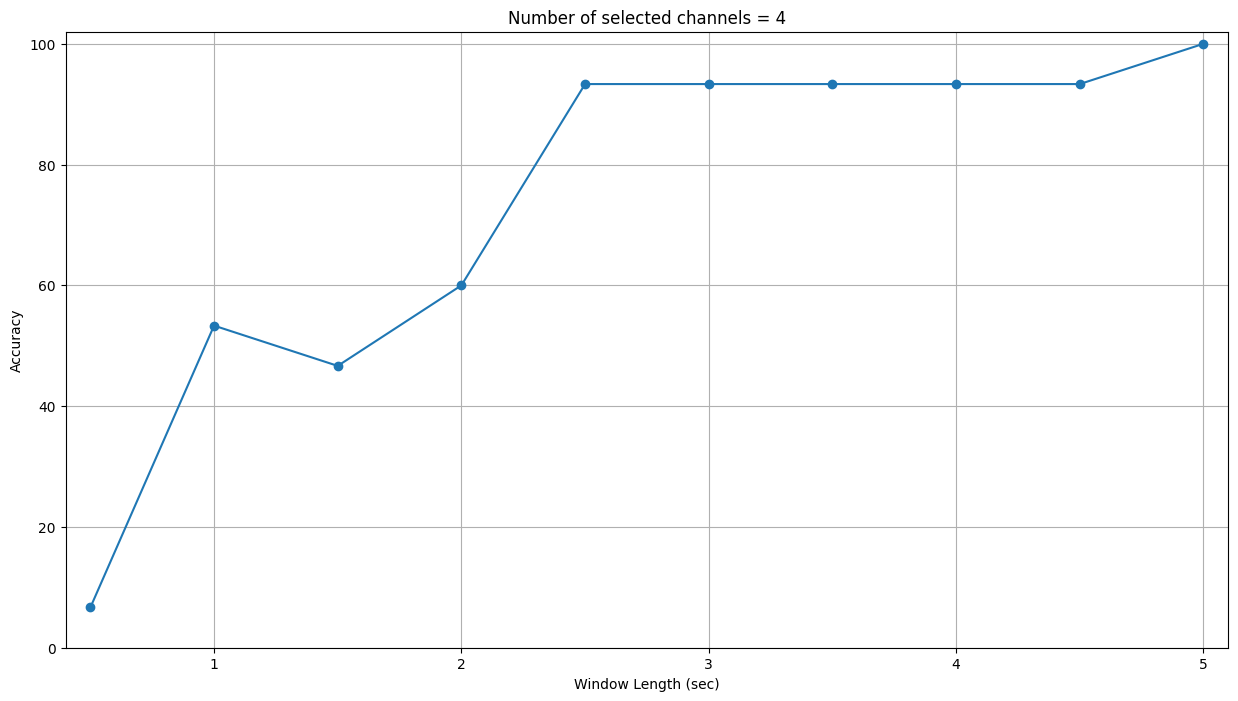

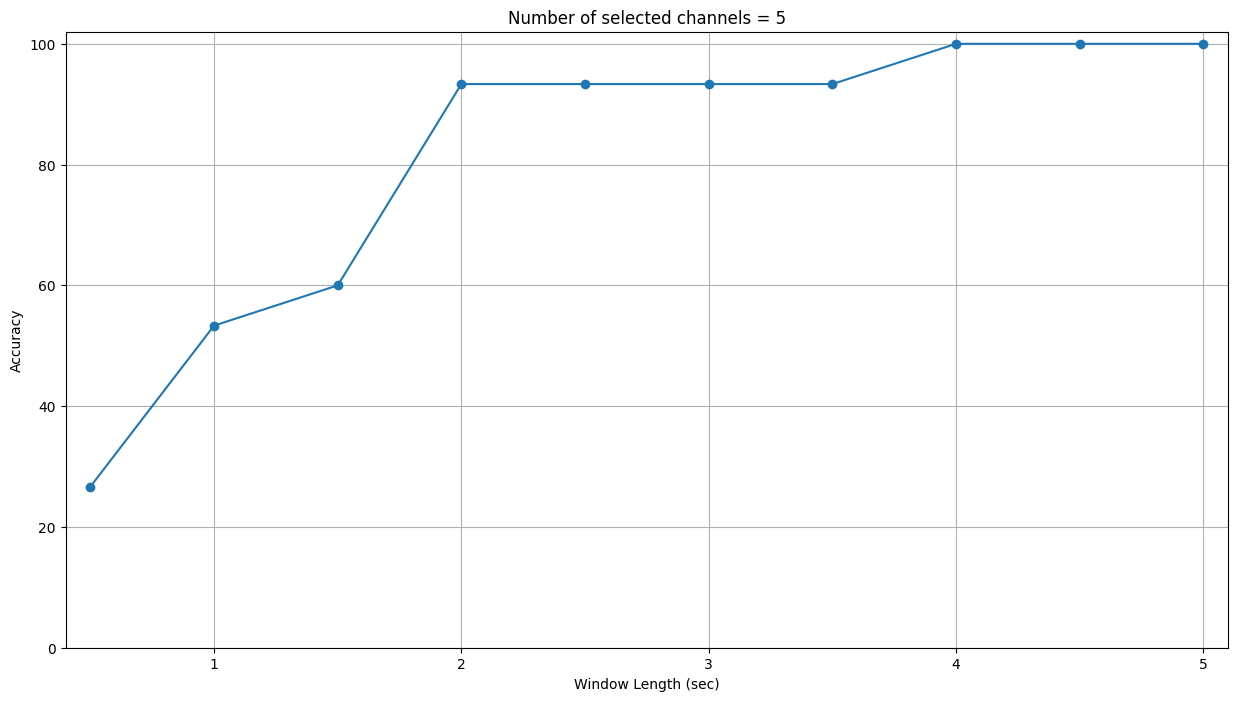

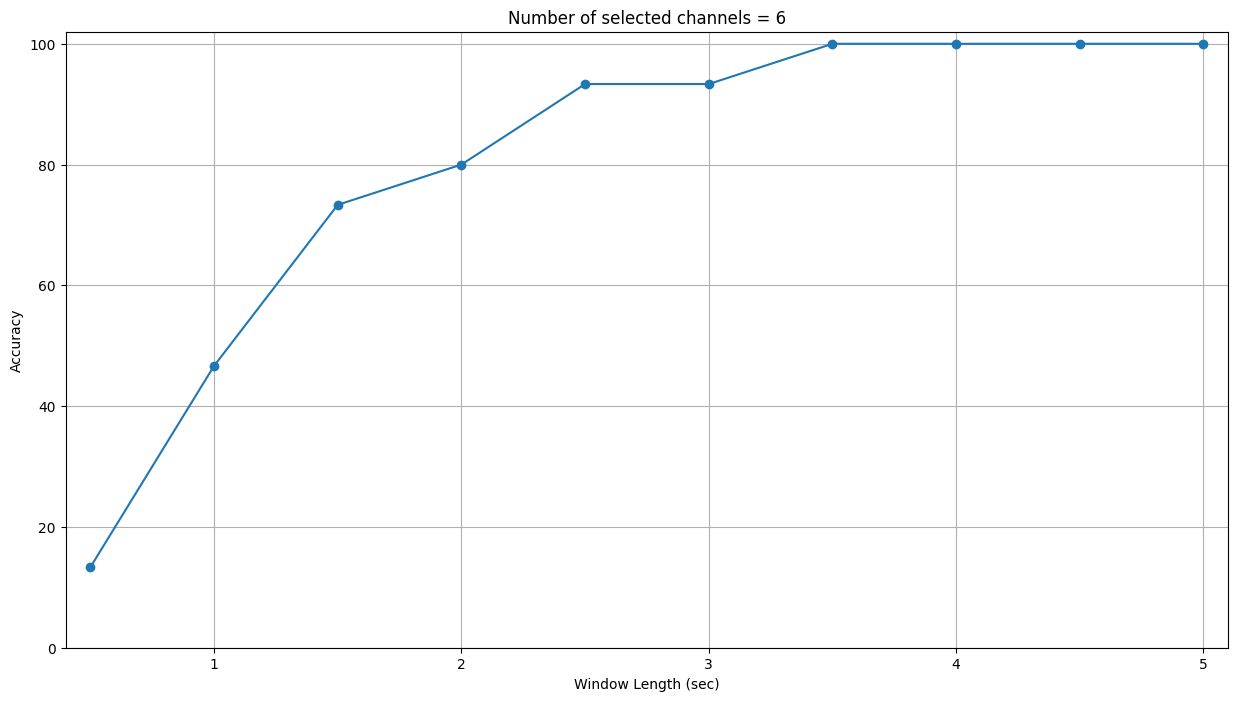

In [13]:
stimulation_frequencies = list(set(Events[0]))

accuracies = np.zeros((len(np.arange(0.5, 5.5, .5)), len(range(1, 7))))
win_cnt = 0
for window_size in np.arange(0.5, 5.5, .5):
    window_samples = int(window_size * fs)
    trials_cca = []
    for event_sample in Event_samples[0]:
        start_sample = int(event_sample)
        end_sample = start_sample + window_samples
        trial_data = filtered_signals[:, start_sample:end_sample]
        trials_cca.append(trial_data)
        
    for num_channels in range(1, 7):
        selected_channels = np.random.choice(range(SSVEP_Signal.shape[0]), size=num_channels, replace=False)
        reduced_trials_cca = [trial[selected_channels, :] for trial in trials_cca]
    
        cca_coefficients = np.zeros((len(stimulation_frequencies), len(reduced_trials_cca)))
    
        for i, frequency in enumerate(stimulation_frequencies):
            t = np.arange(0, window_size, 1 / fs)
            if i>2:
                Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 8-i)).T
            else:
                Y_f = np.vstack([np.sin(2 * np.pi * k * frequency * t), np.cos(2 * np.pi * k * frequency * t)] for k in range(1, 7-i)).T
    
            for j, trial_data in enumerate(reduced_trials_cca):
                X = trial_data.T
                cca = CCA(n_components=min(X.shape[1], Y_f.shape[1]))
                X_c, Y_c = cca.fit_transform(X, Y_f)
                U, S, Vh = np.linalg.svd(np.dot(X_c.T, Y_c))
                cca_coefficients[i, j] = np.max(S)
                
        stimulation_frequencies = np.array(stimulation_frequencies)
        dominant_frequencies = stimulation_frequencies[np.argmax(cca_coefficients, axis=0)]
    
        true_labels = Events[0]
        accuracy = np.mean(dominant_frequencies == true_labels)
        accuracies[win_cnt, num_channels-1] += accuracy*100
    win_cnt += 1

print('===================================================================================================================\n')
print('============================================ Accuracy vs Window Length ============================================\n')
print('===================================================================================================================\n')
for ch in range(6):
    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(0.5, 5.5, .5), accuracies[:, ch], marker='o')
    plt.title('Number of selected channels = {}'.format(ch+1))
    plt.xlabel('Window Length (sec)')
    plt.ylabel('Accuracy')
    plt.ylim([0, 102])
    plt.xlim([.4, 5.1])
    plt.grid(True)
    plt.show()
